In [29]:
import pandas as pd
import numpy as np

from hydra import initialize, compose
from omegaconf import OmegaConf

import mlflow

import os
os.chdir('../../../')

from src.models import train_tf as ttf
from src.models import train_helpers as th
from src.models import test_tf as testtf

from tqdm import tqdm

from matplotlib import pyplot as plt

In [3]:
def load_params(params_dict):
    res_dict = {}
    for key in params_dict:
        val = params_dict[key]
        if val == 'True':
            res_dict[key] = True
        elif val == 'False': 
            res_dict[key] = False
        else:
            if val.find('.') > -1:
                try:
                    res_dict[key] = float(val)
                except:
                    res_dict[key] = val
            else:
                try:
                    res_dict[key] = int(val)
                except:
                    res_dict[key] = val
    return res_dict

In [3]:
with initialize(version_base=None, config_path='../../../conf/'):
    cfg = compose(config_name='config')
cfg = cfg.test_tf

cfg.mlflow_source_experiment_name = 'Q2i_tf_bio-clinicalbert_tpe_100t_220925_121844'
cfg.mlflow_run_id = '52e6735eafa542238a1fda2ee07c3b08'
cfg.target_var = 'Q2i'

mlflow.set_tracking_uri(cfg.mlflow_tracking_dir)

# Load the model parameters from cross-validation
exper = mlflow.get_experiment_by_name(cfg.mlflow_source_experiment_name)
run = mlflow.get_run(cfg.mlflow_run_id)
run_params = run.data.params
train_cfg = OmegaConf.create(load_params(run_params))

print(train_cfg)

{'learning_rate': 0.00021362401924961673, 'match_factor': 0.9176402939310753, 'invert_target': False, 'mlflow_dir': 'mlruns2', 'fit_final': True, 'random_state': 43, 'save_steps': -1, 'mlflow_tracking_dir': './mlruns2', 'save_eval_checkpoints': False, 'use_multiprocessing_for_evaluation': False, 'qual_exclude_level4': False, 'submodel': 'emilyalsentzer/Bio_ClinicalBERT', 'n_splits': 1, 'max_seq_length': 256, 'train_path': 'data/processed/train.pkl', 'do_replacement': False, 'text_var': 'comment', 'mlflow_experiment_name': 'Q2i_tf_bio-clinicalbert_tpe_100t_220925_121844', 'num_train_epochs': 1, 'overwrite_output_dir': True, 'conda_yaml_path': './conda.yaml', 'aug_factor': 1.101557639569787, 'output_dir': 'tf_outputs', 'train_batch_size': 16, 'test_size': 0.25, 'use_multiprocessing': False, 'do_aug': True, 'model': 'bert', 'objective_metric': 'mean_balanced_accuracy', 'target_var': 'Q2i', 'save_model_every_epoch': False}


In [4]:
Xtr, ytr = th.load_data(train_cfg, train=True)
model = ttf.train_tf_model(train_cfg, Xtr, ytr)

hftfmodel = model.model
tok = model.tokenizer

from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    hftfmodel,
    tok)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [5]:
df_train = pd.read_pickle('data/processed/train.pkl')
df_test = pd.read_pickle('data/processed/test.pkl')
df = pd.concat([df_train, df_test])

In [6]:
attrib_dict = {}
n_skipped = 0
for comment in tqdm(df.comment):
    seq_len = len(comment.split(' '))
    if seq_len > 75:
        n_skipped += 1
        continue
    else:
        attribs = cls_explainer(comment, class_name='LABEL_1')
        for w, score in attribs:
            try:
                attrib_dict[w].append(score)
            except KeyError:
                attrib_dict[w] = [score]
print(f'Skipped for length reasons: {n_skipped}')

100%|██████████| 2500/2500 [04:36<00:00,  9.05it/s]

Skipped for length reasons: 294


In [16]:
word_scores = {k : {'mean': np.mean(v), 'std': np.std(v), 'count': len(v)} for k, v in attrib_dict.items()}
word_scores = pd.DataFrame(word_scores).T
word_scores = word_scores.sort_values('mean')

In [40]:
word_scores[word_scores['count'] >= 10].head(10)

,mean,std,count
Remember,-0.868443,0.093152,21.0
##ue,-0.641557,0.165069,18.0
##bal,-0.505203,0.331737,14.0
you,-0.503394,0.269872,77.0
Need,-0.476959,0.222717,26.0
discussed,-0.471665,0.314301,79.0
Consider,-0.396730,0.249953,12.0
around,-0.362943,0.309237,44.0
Disc,-0.353498,0.208702,38.0
##tin,-0.351761,0.147448,21.0


In [22]:
word_scores.to_dict()

{'mean': {'*': -1.0,
  'recommend': -0.9244867306892215,
  'Know': -0.9101627063604517,
  'Please': -0.8930585693496879,
  'Remember': -0.8684428906901096,
  '##kle': -0.8593337480100692,
  '##ues': -0.8179824613562475,
  'encourage': -0.7720792343212682,
  'remember': -0.7615519873649763,
  'Planning': -0.7508488660800201,
  'knowing': -0.7362826353338795,
  'suggested': -0.698846105548593,
  'avoid': -0.6817490803898048,
  'documenting': -0.6450883208323969,
  '##ue': -0.6415570799161271,
  'Ang': -0.6311409136361376,
  'forget': -0.6131786429425641,
  'Listen': -0.6084038143735016,
  'Progress': -0.6056007724650913,
  '##eration': -0.6053516987949796,
  '##lose': -0.5964672890557493,
  'minimize': -0.5892731925951453,
  'Change': -0.5756940299131666,
  'Teaching': -0.5720064655075523,
  'proposed': -0.5634614117893352,
  'Try': -0.561070382307072,
  'forgot': -0.5584002491484831,
  'Be': -0.5422635925874522,
  'Better': -0.5362759858495733,
  'Clean': -0.5330750971365577,
  'Just': 

In [32]:
from matplotlib.cm import get_cmap

In [ ]:
get_cmap()

In [50]:
def gen_wc_from_scores(word_scores, max_words=500, positive=True, 
    count_thresh=10, width=800, height=400, figwidth=10, figheight=5, 
    background_color='white', colormap='Reds',
    exclude_partwords=True):
    wc = WordCloud(max_words=500, background_color=background_color, colormap=colormap, width=width, height=height)
    if exclude_partwords:
        word_scores = word_scores[~word_scores.index.str.contains('##')]
    wc.generate_from_frequencies(
        word_scores[
            (word_scores['count'] >= count_thresh) &
            ((word_scores['mean'] >= 0) if positive else (word_scores['mean'] < 0))
        ]['mean'].abs().to_dict()
    )

    plt.figure(figsize=(figwidth, figheight))
    plt.imshow(wc)
    plt.axis('off')

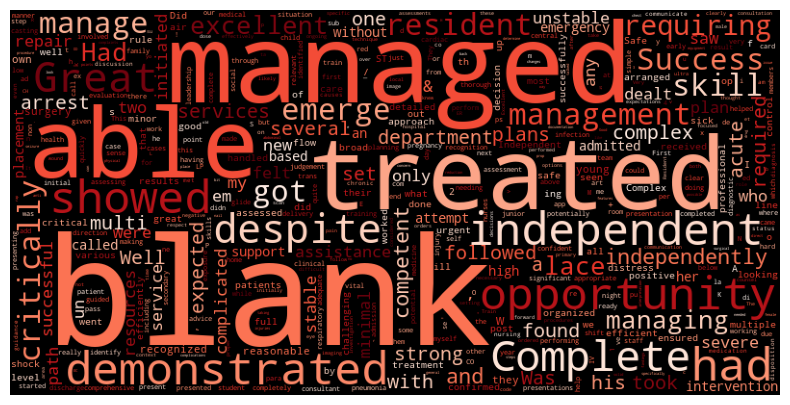

In [52]:
gen_wc_from_scores(word_scores, background_color='black')

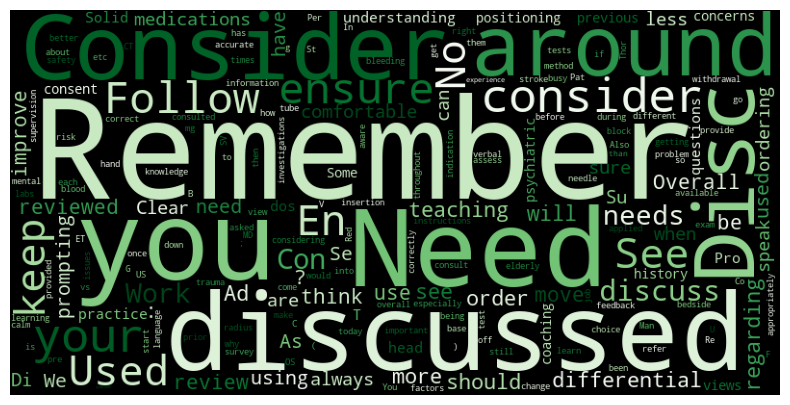

In [53]:
gen_wc_from_scores(word_scores, background_color='black', positive=False, colormap='Greens')

---

In [1]:
import pandas as pd
import numpy as np

from hydra import initialize, compose
from omegaconf import OmegaConf

import mlflow

import os
os.chdir('../../../')

from src.models import train_tf as ttf
from src.models import train_helpers as th
from src.models import test_tf as testtf

from tqdm import tqdm

from matplotlib import pyplot as plt

/home/maxspad/anaconda3/envs/nqmtf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with initialize(version_base=None, config_path='../../../conf/'):
    cfg = compose(config_name='config')
cfg = cfg.test_tf

cfg.mlflow_source_experiment_name = 'QUAL_tf_manual'
cfg.mlflow_run_id = 'ac5719077e6c4ac9a18a4c5d917eac35'
cfg.target_var = 'QUAL'

mlflow.set_tracking_uri(cfg.mlflow_tracking_dir)

# Load the model parameters from cross-validation
exper = mlflow.get_experiment_by_name(cfg.mlflow_source_experiment_name)
run = mlflow.get_run(cfg.mlflow_run_id)
run_params = run.data.params
train_cfg = OmegaConf.create(load_params(run_params))

print(train_cfg)

NameError: name 'load_params' is not defined

In [ ]:
Xtr, ytr = th.load_data(train_cfg, train=True)
model = ttf.train_tf_model(train_cfg, Xtr, ytr)

hftfmodel = model.model
tok = model.tokenizer

from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    hftfmodel,
    tok)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [ ]:
df_train = pd.read_pickle('data/processed/train.pkl')
df_test = pd.read_pickle('data/processed/test.pkl')
df = pd.concat([df_train, df_test])

In [ ]:
attrib_dict = {}
n_skipped = 0
for comment in tqdm(df.comment):
    seq_len = len(comment.split(' '))
    if seq_len > 75:
        n_skipped += 1
        continue
    else:
        attribs = cls_explainer(comment, class_name='LABEL_1')
        for w, score in attribs:
            try:
                attrib_dict[w].append(score)
            except KeyError:
                attrib_dict[w] = [score]
print(f'Skipped for length reasons: {n_skipped}')

100%|██████████| 2500/2500 [04:36<00:00,  9.05it/s]

Skipped for length reasons: 294


In [ ]:
word_scores = {k : {'mean': np.mean(v), 'std': np.std(v), 'count': len(v)} for k, v in attrib_dict.items()}
word_scores = pd.DataFrame(word_scores).T
word_scores = word_scores.sort_values('mean')

In [ ]:
word_scores[word_scores['count'] >= 10].head(10)

,mean,std,count
Remember,-0.868443,0.093152,21.0
##ue,-0.641557,0.165069,18.0
##bal,-0.505203,0.331737,14.0
you,-0.503394,0.269872,77.0
Need,-0.476959,0.222717,26.0
discussed,-0.471665,0.314301,79.0
Consider,-0.396730,0.249953,12.0
around,-0.362943,0.309237,44.0
Disc,-0.353498,0.208702,38.0
##tin,-0.351761,0.147448,21.0


In [ ]:
word_scores.to_dict()

{'mean': {'*': -1.0,
  'recommend': -0.9244867306892215,
  'Know': -0.9101627063604517,
  'Please': -0.8930585693496879,
  'Remember': -0.8684428906901096,
  '##kle': -0.8593337480100692,
  '##ues': -0.8179824613562475,
  'encourage': -0.7720792343212682,
  'remember': -0.7615519873649763,
  'Planning': -0.7508488660800201,
  'knowing': -0.7362826353338795,
  'suggested': -0.698846105548593,
  'avoid': -0.6817490803898048,
  'documenting': -0.6450883208323969,
  '##ue': -0.6415570799161271,
  'Ang': -0.6311409136361376,
  'forget': -0.6131786429425641,
  'Listen': -0.6084038143735016,
  'Progress': -0.6056007724650913,
  '##eration': -0.6053516987949796,
  '##lose': -0.5964672890557493,
  'minimize': -0.5892731925951453,
  'Change': -0.5756940299131666,
  'Teaching': -0.5720064655075523,
  'proposed': -0.5634614117893352,
  'Try': -0.561070382307072,
  'forgot': -0.5584002491484831,
  'Be': -0.5422635925874522,
  'Better': -0.5362759858495733,
  'Clean': -0.5330750971365577,
  'Just': 

In [ ]:
from matplotlib.cm import get_cmap

In [ ]:
get_cmap()

In [ ]:
def gen_wc_from_scores(word_scores, max_words=500, positive=True, 
    count_thresh=10, width=800, height=400, figwidth=10, figheight=5, 
    background_color='white', colormap='Reds',
    exclude_partwords=True):
    wc = WordCloud(max_words=500, background_color=background_color, colormap=colormap, width=width, height=height)
    if exclude_partwords:
        word_scores = word_scores[~word_scores.index.str.contains('##')]
    wc.generate_from_frequencies(
        word_scores[
            (word_scores['count'] >= count_thresh) &
            ((word_scores['mean'] >= 0) if positive else (word_scores['mean'] < 0))
        ]['mean'].abs().to_dict()
    )

    plt.figure(figsize=(figwidth, figheight))
    plt.imshow(wc)
    plt.axis('off')

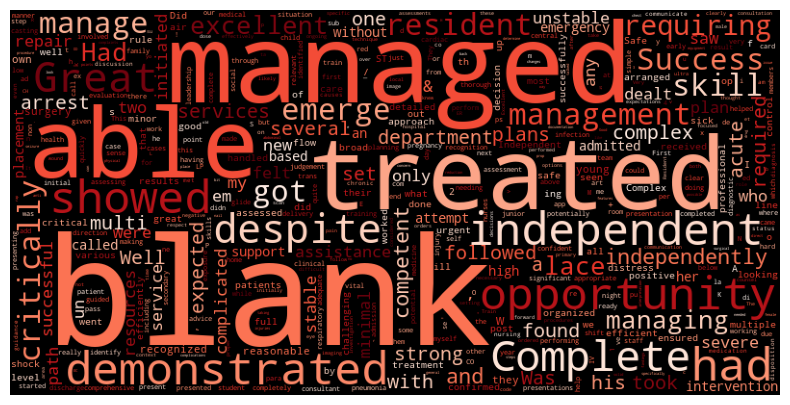

In [ ]:
gen_wc_from_scores(word_scores, background_color='black')

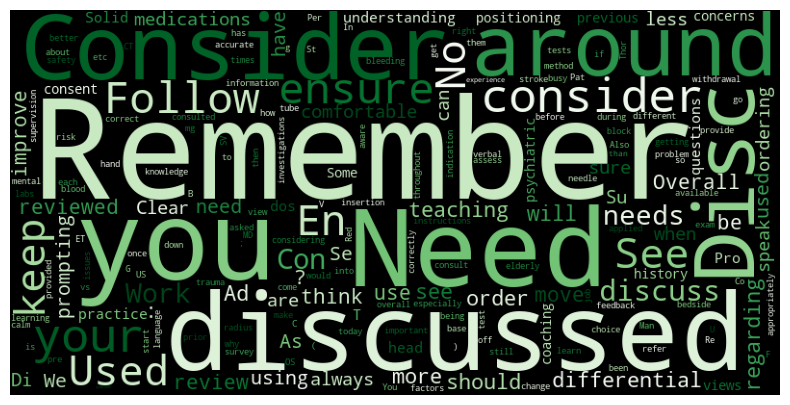

In [ ]:
gen_wc_from_scores(word_scores, background_color='black', positive=False, colormap='Greens')